# Classifiers - low vs mid vs high complexity - with TFv1
Exploring different classifiers with with the contractive autoencoder for the NC task. It needs the TFv1 compatibility.

#### Table of contents:  

autoencoders:  
[Contractive Autoencoder](#Contractive-Autoencoder)  

classifiers:  
[Simple dense classifier](#Simple-dense-classifier)  
[LSTM-based classifier](#LSTM-based-classifier)  
[kNN](#kNN)  
[SVC](#SVC)  
[Random Forest](#Random-Forest)  
[XGBoost](#XGBoost)  

In [1]:
import datareader # made by the previous author for reading the collected data
import dataextractor # same as above
import pandas
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, Nadam
# need to disable eager execution for .get_weights() in contractive autoencoder loss to work
tf.compat.v1.disable_eager_execution() # required for the contractive autoencoder
import tensorflow.keras.backend as K
tf.keras.backend.set_floatx('float32') # call this, to set keras to use float32 to avoid a warning message
metrics = ['accuracy']

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier

import json
from datetime import datetime
import warnings
import matplotlib.pyplot as plt

In [2]:
# from https://github.com/ageron/handson-ml/blob/master/extra_tensorflow_reproducibility.ipynb
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                        inter_op_parallelism_threads=1)

with tf.compat.v1.Session(config=config) as sess:
    #... this will run single threaded
    pass

In [3]:
import random

random.seed(1)
np.random.seed(4)
tf.random.set_seed(2)

In [4]:
# Start the notebook in the terminal with "PYTHONHASHSEED=0 jupyter notebook" 
# or in anaconda "set PYTHONHASHSEED=0" then start jupyter notebook
import os
if os.environ.get("PYTHONHASHSEED") != "0":
    raise Exception("You must set PYTHONHASHSEED=0 when starting the Jupyter server to get reproducible results.")

This is modfied original author's code for reading data:

In [5]:
def model_train(model, x_train, y_train, batch_size, epochs, x_valid, y_valid, x_test, y_test):
    """Train model with the given training, validation, and test set, with appropriate batch size and # epochs."""
    epoch_data = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid), verbose=0)
    score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    acc = score[1]
    score = score[0]
    return score, acc, epoch_data


In [6]:
def get_task_complexities_timeframes_br_hb(path, ident, seconds):
    """Returns raw data along with task complexity class.
    TODO: join functions. Add parameter to choose different task types and complexities"""

    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))
    breathing = np.empty((0,12))
    heartbeat = np.empty((0,10))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    
    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17
        tmp_tasks_data = np.empty((0, seconds*samp_rate))
        tmp_tasks_y = np.empty((0, 1))
        tmp_breathing = np.empty((0,12))
        tmp_heartbeat = np.empty((0,10))
        
        ### task complexity classification
#         if cog_res['task_complexity'][task_num_table] == 'medium':
#             continue

        if cog_res['task_label'][task_num_table] != 'NC':
            continue
            
        map_compl = {
            'low': 0,
            'medium': 2,
            'high': 1
        }

        
        for j in range(10):
            new_end = int(busy_n[task_num_table][1] - j * samp_rate)
            new_start = int(new_end - samp_rate*30)
            dataextract = dataextractor.DataExtractor(data[0][new_start:new_end],
                                                      data[1][new_start:new_end], samp_rate)
            # get extracted features for breathing
            tmpBR = dataextract.extract_from_breathing_time(data[0][new_start:new_end],
                                                                 data[1][new_start:new_end])
            #get extracted features for heartbeat
            tmpHB = dataextract.extract_from_heartbeat_time(data[0][new_start:new_end],
                                                                 data[1][new_start:new_end])
            
            try:
                
                tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract.y[-samp_rate * seconds:]))
                tmp_tasks_y = np.vstack((tmp_tasks_y, map_compl.get(cog_res['task_complexity'][task_num_table])))

                tmp_breathing = np.vstack((tmp_breathing, tmpBR.to_numpy(dtype='float64', na_value=0)[0][:-1]))
                tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB.to_numpy(dtype='float64', na_value=0)[0][:-1]))
                
            except ValueError:
#                 print(ident)
                continue

            tasks_data = np.vstack((tasks_data, dataextract.y))
            tasks_y = np.vstack((tasks_y, map_compl.get(cog_res['task_complexity'][task_num_table])))
            breathing = np.vstack((breathing, tmpBR.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            heartbeat = np.vstack((heartbeat, tmpHB.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            
    return tasks_data, tasks_y, breathing, heartbeat

In [7]:
def get_data_from_idents_br_hb(path, idents, seconds):
    """Go through all user data and take out windows of only <seconds> long time frames,
    along with the given class (from 'divide_each_task' function).
    """
    samp_rate = 43  # hard-coded sample rate
    data, ys = np.empty((0, samp_rate*seconds)), np.empty((0, 1))
    brs = np.empty((0,12))
    hbs = np.empty((0,10))
    combined = np.empty((0,22))
    
    # was gettign some weird warnings; stack overflow said to ignore them
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for i in idents:
            #x, y, br, hb = get_busy_vs_relax_timeframes_br_hb(path, i, seconds) # either 'get_busy_vs_relax_timeframes',
            # get_engagement_increase_vs_decrease_timeframes, get_task_complexities_timeframes or get_TLX_timeframes
            x, y, br, hb = get_task_complexities_timeframes_br_hb(path, i, seconds)
            
            data = np.vstack((data, x))
            ys = np.vstack((ys, y))
            brs = np.vstack((brs, br))
            hbs = np.vstack((hbs, hb))
        combined = np.hstack((brs,hbs))
    
    return data, ys, brs, hbs, combined

In [8]:
# Accs is a dictionary which holds 1d arrays of accuracies in each key
# except the key 'test id' which holds strings of the id which yielded the coresponding accuracies
def print_accs_stats(accs):
    
    printDict = {}
    # loop over each key
    for key in accs:
    
        if (key == 'test id'):
            # skip calculating ids
            continue
        printDict[key] = {}
        tmpDict = printDict[key]
        # calculate and print some statistics
        tmpDict['min'] = np.min(accs[key])
        tmpDict['max'] = np.max(accs[key])
        tmpDict['mean'] = np.mean(accs[key])
        tmpDict['median'] = np.median(accs[key])
    
    print(pandas.DataFrame.from_dict(printDict).to_string())

In [9]:
def set_random_seeds():
    # clear session and set seeds again
    # cannot clear session due to tf.compat.v1 graphs, but add tf.compat.v1.set_random_seed
#     K.clear_session()
    tf.compat.v1.set_random_seed(2)
    random.seed(1)
    np.random.seed(4)
    tf.random.set_seed(2)

## Prepare data

Initialize variables:

In [10]:
# initialize a dictionary to store accuracies for comparison
accuracies = {}

# used for reading the data into an array
seconds = 30  # time window length
samp_rate = 43  # hard-coded sample rate
phase_shape = np.empty((0, samp_rate*seconds))
y_shape = np.empty((0, 1))
breathing_shape = np.empty((0,12))
heartbeat_shape = np.empty((0,10))
combined_shape = np.empty((0,22))
idents = ['2gu87', 'iz2ps', '1mpau', '7dwjy', '7swyk', '94mnx', 'bd47a', 'c24ur', 'ctsax', 'dkhty', 'e4gay',
              'ef5rq', 'f1gjp', 'hpbxa', 'pmyfl', 'r89k1', 'tn4vl', 'td5pr', 'gyqu9', 'fzchw', 'l53hg', '3n2f9',
              '62i9y']
path = '../../../../../StudyData/'


# change to len(idents) at the end to use all the data
n = len(idents)

In [11]:
# load all phase data to use for training autoencoders
phase_all_train = get_data_from_idents_br_hb(path, idents[:-2], seconds)[0]
# Scale each row with MinMax to range [0,1]
phase_all_train = MinMaxScaler().fit_transform(phase_all_train.T).T

# load all validation phase data to use for training autoencoders
phase_all_valid = get_data_from_idents_br_hb(path, idents[-2:], seconds)[0]
# Scale each row with MinMax to range [0,1]
phase_all_valid = MinMaxScaler().fit_transform(phase_all_valid.T).T

In [12]:
# Holds all the data so it doesnt have to be read from file each time
data_dict = {}

Fill the data dictionary:

In [13]:
for ident in idents:
    
    # initialize ident in 
    data_dict[ident] = {}
    tmpDataDict = data_dict[ident]
    
    # read data
    phase, y, breathing, heartbeat, combined = get_data_from_idents_br_hb(path, [ident], seconds)
    
    # load data into dictionary
    tmpDataDict['phase'] = phase
    tmpDataDict['y'] = y
    tmpDataDict['breathing'] = breathing
    tmpDataDict['heartbeat'] = heartbeat
    tmpDataDict['combined'] = combined

## Autoencoders  
Train autoencoders to save their encoded representations in the data dictionary:

In [14]:
# AE Training params
batch_size = 128
epochs = 1000
encoding_dim = 30
ae_encoded_shape = np.empty((0,encoding_dim))

In [15]:
def compare_plot_n(data1, data2, plot_n=10):
    
    #plot data1 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data1[i])

    #plot data2 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data2[i])

#### Contractive Autoencoder
From: https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/

In [16]:
# define a function to be able to access the autoencoder in the loss funciton
def loss_with_params(autoencoder):
    # loss function from https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/
    def contractive_loss(y_pred, y_true):

        lam = 1e-4
        mse = K.mean(K.square(y_true - y_pred), axis=1)

        W = K.variable(value=autoencoder.get_layer('encoded').get_weights()[0])  # N x N_hidden
        W = K.transpose(W)  # N_hidden x N
        h = autoencoder.get_layer('encoded').output
        dh = h * (1 - h)  # N_batch x N_hidden

        # N_batch x N_hidden * N_hidden x 1 = N_batch x 1
        contractive = lam * K.sum(dh**2 * K.sum(W**2, axis=1), axis=1)

        return mse + contractive
    return contractive_loss

In [17]:
def contractive_ae(x, encoding_dim=64, encoded_as_model=False):
    # From https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/

    input_data = Input(shape=x[0].shape, name="input")
    encoded = Dense(encoding_dim, activation='relu', name='encoded')(input_data)
    outputs = Dense(x[0].shape[0], activation='sigmoid', name="output")(encoded)

    autoencoder = Model(input_data, outputs, name="autoencoder")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss=loss_with_params(autoencoder), metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [18]:
set_random_seeds()
ct_ae, ct_enc = contractive_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
ct_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

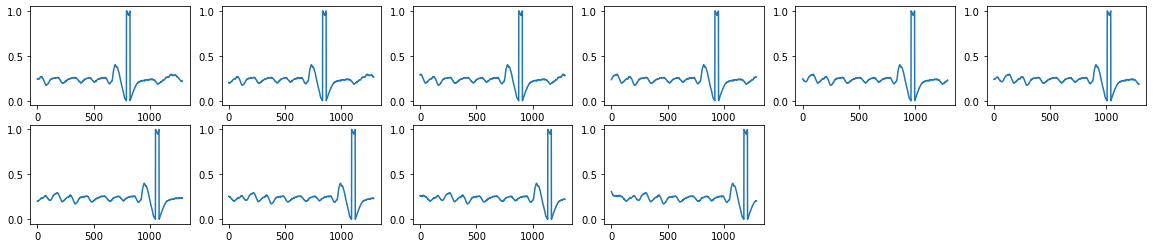

<Figure size 432x288 with 0 Axes>

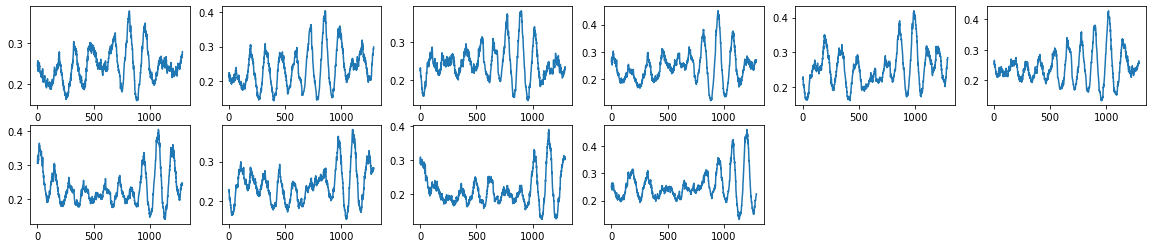

In [19]:
data2 = ct_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

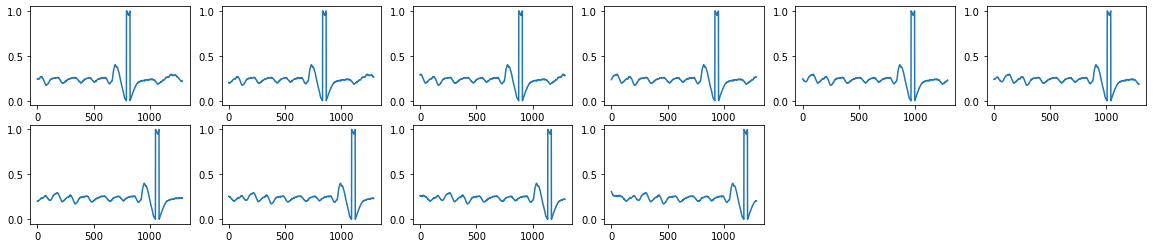

<Figure size 432x288 with 0 Axes>

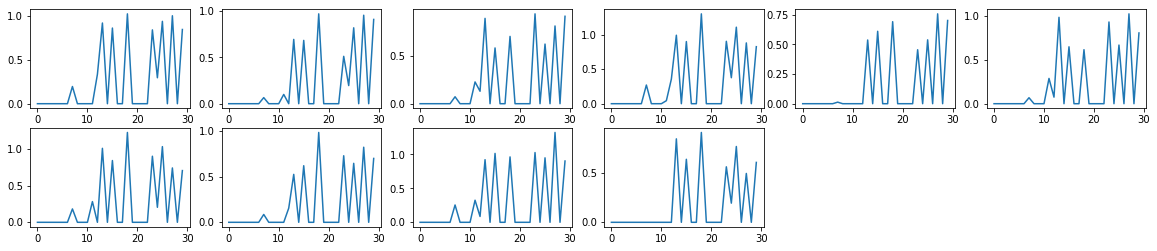

In [20]:
data2 = ct_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2)

Store the encoded representations in the data dictionary:

In [21]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    ct_data = ct_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['contractive_encoded'] = ct_data

Helper function to get data from the dictionary:

In [22]:
def get_ident_data_from_dict(idents, data_dict):
    
    # Initialize data variables
    y = y_shape.copy()
    phase = phase_shape.copy()
    contractive_encoded = ae_encoded_shape.copy()
    
    # Stack data form each ident into the variables
    for tmp_id in idents:
        phase = np.vstack((phase, data_dict[tmp_id]['phase']))
        y = np.vstack((y, data_dict[tmp_id]['y']))
        contractive_encoded = np.vstack((contractive_encoded, data_dict[tmp_id]['contractive_encoded']))
    
    return y, phase, contractive_encoded

## Classifiers

#### Helper loop function definition  
A function that loops over all the data and calls the classifiers with it then stores the returned accuracies.

In [23]:
def helper_loop(classifier_function_train, idents, n=5, num_loops_to_average_over=1, should_scale_data=True):
    #returns a dictionary with accuracies

    # set the variables in the dictionary
    accs = {}
    accs['phase'] = []
    accs['contractive'] = []
    accs['test id'] = []
    start_time = datetime.now()

    with tf.compat.v1.Session(config=config) as sess:
        # leave out person out validation
        for i in range(n):

            # print current iteration and time elapsed from start
            print("iteration:", i+1, "of", n, "; time elapsed:", datetime.now()-start_time)

            ## ----- Data preparation:
            validation_idents = [idents[i]]
            test_idents = [idents[i-1]]

            train_idents = []
            for ident in idents:
                if (ident not in test_idents) and (ident not in validation_idents):
                    train_idents.append(ident)

            # save test id to see which id yielded which accuracies
            accs['test id'].append(test_idents[0])

            # Load train data
            train_data = get_ident_data_from_dict(train_idents, data_dict)
            y_train = train_data[0]

            # Load validation data
            valid_data = get_ident_data_from_dict(validation_idents, data_dict)
            y_valid = valid_data[0]

            # Load test data
            test_data = get_ident_data_from_dict(test_idents, data_dict)
            y_test = test_data[0]

            data_names_by_index = ['y', 'phase', 'contractive']

            # Loop over all data that will be used for classification and send it to the classifier
            # index 0 is y so we skip it
            for index in range(1, len(test_data)):
                set_random_seeds()
                train_x = train_data[index]
                valid_x = valid_data[index]
                test_x = test_data[index]

                # Scale data
                if should_scale_data:
                    # Scale with standard scaler
                    sscaler = StandardScaler()
                    sscaler.fit(train_x)
                    train_x = sscaler.transform(train_x)

                    # Scale valid and test with train's scaler
                    valid_x = sscaler.transform(valid_x)
                    test_x = sscaler.transform(test_x)
                
                # Initialize variables
                tmp_acc = []
                data_name = data_names_by_index[index]

                for index in range(num_loops_to_average_over):
                    curr_acc = classifier_function_train(train_x, y_train, valid_x, y_valid, test_x, y_test, data_name)
                    tmp_acc.append(curr_acc)

                # Store accuracy
                curr_acc = np.mean(tmp_acc)
                accs[data_name].append(curr_acc)


        # Print total time required to run this
        end_time = datetime.now()
        elapsed_time = end_time - start_time
        print("Completed!", "Time elapsed:", elapsed_time)
    
    return accs

#### Simple dense classifier

Define the classifier:

In [24]:
params_dense_phase = {
    'dropout': 0.4,
    'hidden_size': 26,
    'activation': 'sigmoid',
    'loss': 'categorical_crossentropy',
    'optimizer': Adam,
    'batch_size': 128,
    'learning_rate': 0.001,
    'epochs': 300
}

In [25]:
params_dense_ae_enc = {
    'dropout': 0.05,
    'hidden_size': 34,
    'activation': 'relu',
    'loss': 'categorical_crossentropy',
    'optimizer': Adam,
    'learning_rate': 0.005,
    'batch_size': 106,
    'epochs': 200
}

In [26]:
def dense_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    # change Ys to categorical (one hot encoding)
    y_train = to_categorical(y_train)
    y_valid = to_categorical(y_valid)
    y_test = to_categorical(y_test)
    
    params = params_dense_ae_enc
    if (data_name == 'phase'):
        params = params_dense_phase
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Dense(params['hidden_size']))
    model.add(Activation(params['activation']))
    model.add(Dense(3))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'](learning_rate=params['learning_rate']),
                  metrics=metrics)
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, x_train, y_train, params['batch_size'], params['epochs'],
                                           x_valid, y_valid, x_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [27]:
accs = helper_loop(dense_train, idents, n=n, should_scale_data=True)

iteration: 1 of 23 ; time elapsed: 0:00:00.008977
iteration: 2 of 23 ; time elapsed: 0:00:12.255807
iteration: 3 of 23 ; time elapsed: 0:00:24.626150
iteration: 4 of 23 ; time elapsed: 0:00:37.296084
iteration: 5 of 23 ; time elapsed: 0:00:50.117356
iteration: 6 of 23 ; time elapsed: 0:01:03.218534
iteration: 7 of 23 ; time elapsed: 0:01:16.731006
iteration: 8 of 23 ; time elapsed: 0:01:30.479166
iteration: 9 of 23 ; time elapsed: 0:01:43.392454
iteration: 10 of 23 ; time elapsed: 0:01:58.750767
iteration: 11 of 23 ; time elapsed: 0:02:14.385284
iteration: 12 of 23 ; time elapsed: 0:02:29.354100
iteration: 13 of 23 ; time elapsed: 0:02:44.322442
iteration: 14 of 23 ; time elapsed: 0:03:00.806691
iteration: 15 of 23 ; time elapsed: 0:03:17.500863
iteration: 16 of 23 ; time elapsed: 0:03:35.266889
iteration: 17 of 23 ; time elapsed: 0:03:52.925207
iteration: 18 of 23 ; time elapsed: 0:04:10.767685
iteration: 19 of 23 ; time elapsed: 0:04:28.952201
iteration: 20 of 23 ; time elapsed: 0:04

In [28]:
accuracies['simple_dense'] = accs

In [29]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.500000,0.333333,62i9y
1,0.466667,0.300000,2gu87
2,0.266667,0.233333,iz2ps
3,0.033333,0.100000,1mpau
4,0.200000,0.200000,7dwjy
5,0.633333,0.533333,7swyk
6,0.333333,0.333333,94mnx
7,0.000000,0.133333,bd47a
8,0.500000,0.566667,c24ur
9,0.566667,0.300000,ctsax


In [30]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.000000     0.100000
max     0.900000     0.666667
mean    0.384058     0.353623
median  0.333333     0.333333


#### LSTM-based classifier  
based on the original author's code

In [31]:
params_lstm_phase = {
    'kernel_size': 4,
    'filters': 32,
    'strides': 2,
    'pool_size': 4,
    'dropout': 0.1,
    'lstm_output_size': 22,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'categorical_crossentropy',
    'optimizer': Nadam,
    'learning_rate': 0.005,
    'batch_size': 168,
    'epochs': 200
}

In [32]:
params_lstm_ae_enc = {
    'kernel_size': 2,
    'filters': 6,
    'strides': 2,
    'pool_size': 2,
    'dropout': 0.01,
    'lstm_output_size': 32,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'categorical_crossentropy',
    'optimizer': Nadam,
    'learning_rate': 0.001,
    'batch_size': 64,
    'epochs': 100
}

In [33]:
def LSTM_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    # change Ys to categorical (one hot encoding)
    y_train = to_categorical(y_train)
    y_valid = to_categorical(y_valid)
    y_test = to_categorical(y_test)
    
    params = params_lstm_ae_enc
    if (data_name == 'phase'):
        params = params_lstm_phase
    
    # Reshape data to fit some layers
    xt_train = x_train.reshape(-1, x_train[0].shape[0], 1)
    xt_valid = x_valid.reshape(-1, x_valid[0].shape[0], 1)
    xt_test = x_test.reshape(-1, x_test[0].shape[0], 1)
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Conv1D(params['filters'],
                     params['kernel_size'],
                     padding='valid',
                     activation=params['activation'],
                     strides=params['strides']))

    model.add(MaxPooling1D(pool_size=params['pool_size']))
    
    if (data_name == 'phase'):
        model.add(Conv1D(params['filters'],
                         params['kernel_size'],
                         padding='valid',
                         activation=params['activation'],
                         strides=params['strides']))
        model.add(MaxPooling1D(pool_size=params['pool_size']))

    model.add(Dropout(params['dropout']))
    model.add(LSTM(params['lstm_output_size']))
    model.add(Dense(3))
    model.add(Activation(params['last_activation']))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'](learning_rate=params['learning_rate']),
                  metrics=['acc'])
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, xt_train, y_train, params['batch_size'], params['epochs'],
                                           xt_valid, y_valid, xt_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [34]:
accs = helper_loop(LSTM_train, idents, n=n)

iteration: 1 of 23 ; time elapsed: 0:00:00.008976
iteration: 2 of 23 ; time elapsed: 0:01:22.966766
iteration: 3 of 23 ; time elapsed: 0:02:47.913208
iteration: 4 of 23 ; time elapsed: 0:04:16.240694
iteration: 5 of 23 ; time elapsed: 0:05:46.244032
iteration: 6 of 23 ; time elapsed: 0:07:14.579799
iteration: 7 of 23 ; time elapsed: 0:08:44.353990
iteration: 8 of 23 ; time elapsed: 0:10:22.600757
iteration: 9 of 23 ; time elapsed: 0:12:04.174205
iteration: 10 of 23 ; time elapsed: 0:13:45.294520
iteration: 11 of 23 ; time elapsed: 0:15:24.185940
iteration: 12 of 23 ; time elapsed: 0:17:01.106410
iteration: 13 of 23 ; time elapsed: 0:18:37.577126
iteration: 14 of 23 ; time elapsed: 0:20:22.009924
iteration: 15 of 23 ; time elapsed: 0:22:07.933984
iteration: 16 of 23 ; time elapsed: 0:23:58.755080
iteration: 17 of 23 ; time elapsed: 0:25:46.685953
iteration: 18 of 23 ; time elapsed: 0:27:36.547549
iteration: 19 of 23 ; time elapsed: 0:29:25.350221
iteration: 20 of 23 ; time elapsed: 0:31

In [35]:
accuracies['LSTM'] = accs

In [36]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.466667,0.333333,62i9y
1,0.666667,0.366667,2gu87
2,0.166667,0.100000,iz2ps
3,0.066667,0.066667,1mpau
4,0.266667,0.233333,7dwjy
5,0.700000,0.333333,7swyk
6,0.800000,0.133333,94mnx
7,0.333333,0.066667,bd47a
8,0.033333,0.466667,c24ur
9,0.500000,0.000000,ctsax


In [37]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.033333     0.000000
max     0.800000     0.700000
mean    0.373913     0.281159
median  0.333333     0.333333


#### kNN

In [38]:
params_knn_phase = {
    'n_neighbors': 5,
    'metric': 'cosine'
}

In [39]:
params_knn_ae_enc = {
    'n_neighbors': 15,
    'metric': 'cosine'
}

In [40]:
from sklearn.neighbors import KNeighborsClassifier

def KNN_classifier(params):
    model = KNeighborsClassifier(n_neighbors=params['n_neighbors'], metric=params['metric'])
    return model

In [41]:
def KNN_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_knn_ae_enc
    if (data_name == 'phase'):
        params = params_knn_phase
    
    model = OneVsRestClassifier(KNN_classifier(params))
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [42]:
accs = helper_loop(KNN_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00.008977
iteration: 2 of 23 ; time elapsed: 0:00:00.190086
iteration: 3 of 23 ; time elapsed: 0:00:00.313344
iteration: 4 of 23 ; time elapsed: 0:00:00.441807
iteration: 5 of 23 ; time elapsed: 0:00:00.559495
iteration: 6 of 23 ; time elapsed: 0:00:00.675184
iteration: 7 of 23 ; time elapsed: 0:00:00.791871
iteration: 8 of 23 ; time elapsed: 0:00:00.908587
iteration: 9 of 23 ; time elapsed: 0:00:01.028240
iteration: 10 of 23 ; time elapsed: 0:00:01.158890
iteration: 11 of 23 ; time elapsed: 0:00:01.275605
iteration: 12 of 23 ; time elapsed: 0:00:01.412330
iteration: 13 of 23 ; time elapsed: 0:00:01.535999
iteration: 14 of 23 ; time elapsed: 0:00:01.654002
iteration: 15 of 23 ; time elapsed: 0:00:01.773683
iteration: 16 of 23 ; time elapsed: 0:00:01.893332
iteration: 17 of 23 ; time elapsed: 0:00:02.007326
iteration: 18 of 23 ; time elapsed: 0:00:02.125012
iteration: 19 of 23 ; time elapsed: 0:00:02.233749
iteration: 20 of 23 ; time elapsed: 0:00

In [43]:
accuracies['kNN'] = accs

In [44]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.300000,0.500000,62i9y
1,0.466667,0.200000,2gu87
2,0.666667,0.666667,iz2ps
3,0.133333,0.100000,1mpau
4,0.400000,0.066667,7dwjy
5,0.500000,0.333333,7swyk
6,0.800000,0.333333,94mnx
7,0.600000,0.066667,bd47a
8,0.666667,0.466667,c24ur
9,0.266667,0.466667,ctsax


In [45]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.100000     0.033333
max     0.800000     0.666667
mean    0.428986     0.307246
median  0.400000     0.333333


####  SVC

In [46]:
params_svc_phase = {
    'C': 10,
    'kernel': 'rbf',
    'gamma': 'scale'
}

In [47]:
params_svc_ae_enc = {
    'C': 3,
    'kernel': 'rbf',
    'gamma': 'auto'
}

In [48]:
from sklearn.svm import SVC

def SVC_classifier(params):
    model = SVC(random_state=42, C=params['C'], kernel=params['kernel'], gamma=params['gamma'])
    return model

In [49]:
def SVC_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_svc_ae_enc
    if (data_name == 'phase'):
        params = params_svc_phase
    
    model = OneVsRestClassifier(SVC_classifier(params))
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [50]:
accs = helper_loop(SVC_train, idents, n=n, num_loops_to_average_over=5)

iteration: 1 of 23 ; time elapsed: 0:00:00.008975
iteration: 2 of 23 ; time elapsed: 0:00:08.317194
iteration: 3 of 23 ; time elapsed: 0:00:16.718627
iteration: 4 of 23 ; time elapsed: 0:00:25.125755
iteration: 5 of 23 ; time elapsed: 0:00:33.525275
iteration: 6 of 23 ; time elapsed: 0:00:41.845826
iteration: 7 of 23 ; time elapsed: 0:00:50.582331
iteration: 8 of 23 ; time elapsed: 0:00:59.166438
iteration: 9 of 23 ; time elapsed: 0:01:07.807761
iteration: 10 of 23 ; time elapsed: 0:01:16.273003
iteration: 11 of 23 ; time elapsed: 0:01:24.722380
iteration: 12 of 23 ; time elapsed: 0:01:33.093349
iteration: 13 of 23 ; time elapsed: 0:01:41.330957
iteration: 14 of 23 ; time elapsed: 0:01:50.078639
iteration: 15 of 23 ; time elapsed: 0:01:57.944012
iteration: 16 of 23 ; time elapsed: 0:02:05.766097
iteration: 17 of 23 ; time elapsed: 0:02:14.218331
iteration: 18 of 23 ; time elapsed: 0:02:22.974973
iteration: 19 of 23 ; time elapsed: 0:02:31.830020
iteration: 20 of 23 ; time elapsed: 0:02

In [51]:
accuracies['SVC'] = accs

In [52]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.466667,0.333333,62i9y
1,0.266667,0.400000,2gu87
2,0.300000,0.033333,iz2ps
3,0.066667,0.266667,1mpau
4,0.033333,0.166667,7dwjy
5,0.400000,0.366667,7swyk
6,0.366667,0.333333,94mnx
7,0.100000,0.000000,bd47a
8,0.300000,0.433333,c24ur
9,0.300000,0.233333,ctsax


In [53]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.033333     0.000000
max     0.700000     0.733333
mean    0.339130     0.350725
median  0.333333     0.333333


#### Random Forest

In [54]:
params_rf_phase = {
    'n_estimators': 180,
    'max_depth': 50,
    'min_samples_split': 4,
    'min_samples_leaf': 1,
    'oob_score': False,
    'ccp_alpha': 0.001
}

In [55]:
params_rf_ae_enc = {
    'n_estimators': 130,
    'max_depth': 100,
    'min_samples_split': 5,
    'min_samples_leaf': 5,
    'oob_score': True,
    'ccp_alpha': 0.005
}

In [56]:
from sklearn.ensemble import RandomForestClassifier
def random_forest_classifier(params):
    model = RandomForestClassifier(random_state=42,
                                   n_estimators = params['n_estimators'],
                                   criterion = 'entropy',
                                   max_depth = params['max_depth'],
                                   min_samples_split = params['min_samples_split'],
                                   min_samples_leaf = params['min_samples_leaf'],
                                   oob_score = params['oob_score'],
                                   ccp_alpha = params['ccp_alpha'],
                                   max_features = 'log2',
                                   bootstrap = True)
    return model

In [57]:
def random_forest_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_rf_ae_enc
    if (data_name == 'phase'):
        params = params_rf_phase
    
    model = OneVsRestClassifier(random_forest_classifier(params))
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [58]:
accs = helper_loop(random_forest_train, idents, n=n, num_loops_to_average_over=5, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00.008977
iteration: 2 of 23 ; time elapsed: 0:00:25.324515
iteration: 3 of 23 ; time elapsed: 0:00:49.961648
iteration: 4 of 23 ; time elapsed: 0:01:14.571565
iteration: 5 of 23 ; time elapsed: 0:01:38.654456
iteration: 6 of 23 ; time elapsed: 0:02:03.325729
iteration: 7 of 23 ; time elapsed: 0:02:25.887235
iteration: 8 of 23 ; time elapsed: 0:02:50.933153
iteration: 9 of 23 ; time elapsed: 0:03:15.224394
iteration: 10 of 23 ; time elapsed: 0:03:36.842804
iteration: 11 of 23 ; time elapsed: 0:03:59.571297
iteration: 12 of 23 ; time elapsed: 0:04:24.022384
iteration: 13 of 23 ; time elapsed: 0:04:45.954069
iteration: 14 of 23 ; time elapsed: 0:05:11.012239
iteration: 15 of 23 ; time elapsed: 0:05:34.754693
iteration: 16 of 23 ; time elapsed: 0:05:58.954388
iteration: 17 of 23 ; time elapsed: 0:06:23.997875
iteration: 18 of 23 ; time elapsed: 0:06:47.372284
iteration: 19 of 23 ; time elapsed: 0:07:08.925510
iteration: 20 of 23 ; time elapsed: 0:07

In [59]:
accuracies['random_forest'] = accs

In [60]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.500000,0.366667,62i9y
1,0.333333,0.333333,2gu87
2,0.333333,0.266667,iz2ps
3,0.333333,0.100000,1mpau
4,0.300000,0.166667,7dwjy
5,0.566667,0.466667,7swyk
6,0.333333,0.333333,94mnx
7,0.100000,0.033333,bd47a
8,0.666667,0.366667,c24ur
9,0.333333,0.333333,ctsax


In [61]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.000000     0.000000
max     0.666667     0.666667
mean    0.365217     0.282609
median  0.333333     0.333333


#### Naive Bayesian

In [62]:
from sklearn.naive_bayes import GaussianNB

def naive_bayesian_classifier():
    model = GaussianNB()
    return model

In [63]:
def naive_bayesian_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = OneVsRestClassifier(naive_bayesian_classifier())
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [64]:
accs = helper_loop(naive_bayesian_train, idents, n=n, should_scale_data=True)

iteration: 1 of 23 ; time elapsed: 0:00:00.008204
iteration: 2 of 23 ; time elapsed: 0:00:00.164977
iteration: 3 of 23 ; time elapsed: 0:00:00.306093
iteration: 4 of 23 ; time elapsed: 0:00:00.438467
iteration: 5 of 23 ; time elapsed: 0:00:00.572871
iteration: 6 of 23 ; time elapsed: 0:00:00.680632
iteration: 7 of 23 ; time elapsed: 0:00:00.785380
iteration: 8 of 23 ; time elapsed: 0:00:00.937392
iteration: 9 of 23 ; time elapsed: 0:00:01.083177
iteration: 10 of 23 ; time elapsed: 0:00:01.225580
iteration: 11 of 23 ; time elapsed: 0:00:01.364882
iteration: 12 of 23 ; time elapsed: 0:00:01.503964
iteration: 13 of 23 ; time elapsed: 0:00:01.641482
iteration: 14 of 23 ; time elapsed: 0:00:01.763035
iteration: 15 of 23 ; time elapsed: 0:00:01.896243
iteration: 16 of 23 ; time elapsed: 0:00:02.047013
iteration: 17 of 23 ; time elapsed: 0:00:02.181104
iteration: 18 of 23 ; time elapsed: 0:00:02.320941
iteration: 19 of 23 ; time elapsed: 0:00:02.454123
iteration: 20 of 23 ; time elapsed: 0:00

In [65]:
accuracies['naive_bayesian'] = accs

In [66]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.333333,0.366667,62i9y
1,0.333333,0.666667,2gu87
2,0.333333,0.200000,iz2ps
3,0.333333,0.000000,1mpau
4,0.666667,0.433333,7dwjy
5,0.333333,0.333333,7swyk
6,0.333333,0.000000,94mnx
7,0.333333,0.000000,bd47a
8,0.666667,0.766667,c24ur
9,0.000000,0.000000,ctsax


In [67]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.000000     0.000000
max     0.666667     0.766667
mean    0.339130     0.326087
median  0.333333     0.333333


#### XGBoost

In [68]:
params_xgb_phase = {
    'n_estimators': 50,
    'max_depth': 50,
    'booster': 'gbtree'
}

In [69]:
params_xgb_ae_enc = {
    'n_estimators': 50,
    'max_depth': 5,
    'booster': 'gbtree'
}

In [70]:
from xgboost import XGBClassifier

def XGBoost_classifier(params):
    model = XGBClassifier(random_state=42,
                         n_estimators=params['n_estimators'],
                         max_depth=params['max_depth'])
    return model

In [71]:
def XGBoost_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_xgb_ae_enc
    if (data_name == 'phase'):
        params = params_xgb_phase
    
    model = OneVsRestClassifier(XGBoost_classifier(params))
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [72]:
accs = helper_loop(XGBoost_train, idents, n=n, num_loops_to_average_over=5, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00.008976
iteration: 2 of 23 ; time elapsed: 0:00:24.229402
iteration: 3 of 23 ; time elapsed: 0:00:47.588747
iteration: 4 of 23 ; time elapsed: 0:01:12.090772
iteration: 5 of 23 ; time elapsed: 0:01:36.125783
iteration: 6 of 23 ; time elapsed: 0:01:59.874912
iteration: 7 of 23 ; time elapsed: 0:02:24.403578
iteration: 8 of 23 ; time elapsed: 0:02:47.658947
iteration: 9 of 23 ; time elapsed: 0:03:11.502223
iteration: 10 of 23 ; time elapsed: 0:03:35.312626
iteration: 11 of 23 ; time elapsed: 0:03:58.927661
iteration: 12 of 23 ; time elapsed: 0:04:23.423391
iteration: 13 of 23 ; time elapsed: 0:04:48.236522
iteration: 14 of 23 ; time elapsed: 0:05:11.006166
iteration: 15 of 23 ; time elapsed: 0:05:35.431703
iteration: 16 of 23 ; time elapsed: 0:06:00.323441
iteration: 17 of 23 ; time elapsed: 0:06:24.744629
iteration: 18 of 23 ; time elapsed: 0:06:49.120873
iteration: 19 of 23 ; time elapsed: 0:07:13.474723
iteration: 20 of 23 ; time elapsed: 0:07

In [73]:
accuracies['XGBoost'] = accs

In [74]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.366667,0.333333,62i9y
1,0.333333,0.400000,2gu87
2,0.566667,0.533333,iz2ps
3,0.500000,0.133333,1mpau
4,0.300000,0.233333,7dwjy
5,0.533333,0.466667,7swyk
6,0.500000,0.333333,94mnx
7,0.200000,0.033333,bd47a
8,0.566667,0.433333,c24ur
9,0.566667,0.333333,ctsax


In [75]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.000000     0.000000
max     0.633333     0.633333
mean    0.360870     0.310145
median  0.366667     0.333333


###  Compare Accuracies

Print min, max, mean, median for each clasifier/autoencoder combination:

In [76]:
for classifier in accuracies:
    print("-----------", classifier + ":", "-----------")
    accs = accuracies[classifier]
    print_accs_stats(accs)
    print("\n")

----------- simple_dense: -----------
           phase  contractive
min     0.000000     0.100000
max     0.900000     0.666667
mean    0.384058     0.353623
median  0.333333     0.333333


----------- LSTM: -----------
           phase  contractive
min     0.033333     0.000000
max     0.800000     0.700000
mean    0.373913     0.281159
median  0.333333     0.333333


----------- kNN: -----------
           phase  contractive
min     0.100000     0.033333
max     0.800000     0.666667
mean    0.428986     0.307246
median  0.400000     0.333333


----------- SVC: -----------
           phase  contractive
min     0.033333     0.000000
max     0.700000     0.733333
mean    0.339130     0.350725
median  0.333333     0.333333


----------- random_forest: -----------
           phase  contractive
min     0.000000     0.000000
max     0.666667     0.666667
mean    0.365217     0.282609
median  0.333333     0.333333


----------- naive_bayesian: -----------
           phase  contractive
min  

Print all accuracies in table form:

In [77]:
for classifier in accuracies:
    print(classifier + ":")
#     print(pandas.DataFrame.from_dict(accuracies[classifier]))
    # Using .to_string() gives nicer loooking results (doesn't split into new line)
    print(pandas.DataFrame.from_dict(accuracies[classifier]).to_string())
    print("\n")

simple_dense:
       phase  contractive test id
0   0.500000     0.333333   62i9y
1   0.466667     0.300000   2gu87
2   0.266667     0.233333   iz2ps
3   0.033333     0.100000   1mpau
4   0.200000     0.200000   7dwjy
5   0.633333     0.533333   7swyk
6   0.333333     0.333333   94mnx
7   0.000000     0.133333   bd47a
8   0.500000     0.566667   c24ur
9   0.566667     0.300000   ctsax
10  0.666667     0.566667   dkhty
11  0.166667     0.333333   e4gay
12  0.466667     0.266667   ef5rq
13  0.333333     0.333333   f1gjp
14  0.333333     0.333333   hpbxa
15  0.133333     0.233333   pmyfl
16  0.333333     0.466667   r89k1
17  0.400000     0.433333   tn4vl
18  0.533333     0.366667   td5pr
19  0.333333     0.433333   gyqu9
20  0.900000     0.666667   fzchw
21  0.100000     0.366667   l53hg
22  0.633333     0.300000   3n2f9


LSTM:
       phase  contractive test id
0   0.466667     0.333333   62i9y
1   0.666667     0.366667   2gu87
2   0.166667     0.100000   iz2ps
3   0.066667     0.066667 